In [1]:
## Importing required libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from time import time
from sklearn.decomposition import PCA, FastICA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier
import os
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

### Data Aggregation Functions

In [3]:
def get_match_label(match):
    ''' Derives a label for a given match. '''
    
    #Define variables
    home_goals = match['home_team_goal']
    away_goals = match['away_team_goal']
     
    label = pd.DataFrame()
    label.loc[0,'match_api_id'] = match['match_api_id'] 

    #Identify match label  
    if home_goals > away_goals:
        label.loc[0,'label'] = "Win"
    if home_goals == away_goals:
        label.loc[0,'label'] = "Draw"
    if home_goals < away_goals:
        label.loc[0,'label'] = "Defeat"

    #Return label        
    return label.loc[0]
    
def get_fifa_stats(match, player_stats):
    ''' Aggregates fifa stats for a given match. '''    
    
    #Define variables
    match_id =  match.match_api_id
    date = match['date']
    players = ['home_player_1', 'home_player_2', 'home_player_3', "home_player_4", "home_player_5",
               "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10",
               "home_player_11", "away_player_1", "away_player_2", "away_player_3", "away_player_4",
               "away_player_5", "away_player_6", "away_player_7", "away_player_8", "away_player_9",
               "away_player_10", "away_player_11"]
    player_stats_new = pd.DataFrame()
    names = []
    
    #Loop through all players
    for player in players:   
            
        #Get player ID
        player_id = match[player]
        
        #Get player stats 
        stats = player_stats[player_stats.player_api_id == player_id]
            
        #Identify current stats       
        current_stats = stats[stats.date < date].sort_values(by = 'date', ascending = False)[:1]
        
        if np.isnan(player_id) == True:
            overall_rating = pd.Series(0)
        else:
            current_stats.reset_index(inplace = True, drop = True)
            overall_rating = pd.Series(current_stats.loc[0, "overall_rating"])

        #Rename stat
        name = "{}_overall_rating".format(player)
        names.append(name)
            
        #Aggregate stats
        player_stats_new = pd.concat([player_stats_new, overall_rating], axis = 1)
    
    player_stats_new.columns = names        
    player_stats_new['match_api_id'] = match_id

    player_stats_new.reset_index(inplace = True, drop = True)

    #Return player stats    
    return player_stats_new.iloc[0]     
      
def get_fifa_data(matches, player_stats, path = None, data_exists = False):
    ''' Gets fifa data for all matches. '''  
    
    #Check if fifa data already exists
    if data_exists == True:
        
        fifa_data = pd.read_pickle(path)
        
    else:
        
        print("Collecting fifa data for each match...")       
        start = time()
        
        #Apply get_fifa_stats for each match
        fifa_data = matches.apply(lambda x :get_fifa_stats(x, player_stats), axis = 1)
        
        end = time()    
        print("Fifa data collected in {:.1f} minutes".format((end - start)/60))
    
    #Return fifa_data
    return fifa_data

def get_overall_fifa_rankings(fifa, get_overall = False):
    ''' Get overall fifa rankings from fifa data. '''
      
    temp_data = fifa
    
    #Check if only overall player stats are desired
    if get_overall == True:
        
        #Get overall stats
        data = temp_data.loc[:,(fifa.columns.str.contains('overall_rating'))]
        data.loc[:,'match_api_id'] = temp_data.loc[:,'match_api_id']
    else:
        #Get all stats except for stat date
        cols = fifa.loc[:,(fifa.columns.str.contains('date_stat'))]
        temp_data = fifa.drop(cols.columns, axis = 1)        
        data = temp_data
    
    #Return data
    return data

def get_last_matches(matches, date, team, x = 10):
    ''' Get the last x matches of a given team. '''
    
    #Filter team matches from matches
    team_matches = matches[(matches['home_team_api_id'] == team) | (matches['away_team_api_id'] == team)]
                           
    #Filter x last matches from team matches
    last_matches = team_matches[team_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    
    #Return last matches
    return last_matches
    
def get_last_matches_against_eachother(matches, date, home_team, away_team, x = 10):
    ''' Get the last x matches of two given teams. '''
    
    #Find matches of both teams
    home_matches = matches[(matches['home_team_api_id'] == home_team) & (matches['away_team_api_id'] == away_team)]    
    away_matches = matches[(matches['home_team_api_id'] == away_team) & (matches['away_team_api_id'] == home_team)]  
    total_matches = pd.concat([home_matches, away_matches])
    
    #Get last x matches
    try:    
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    except:
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:total_matches.shape[0],:]
        
        #Check for error in data
        if(last_matches.shape[0] > x):
            print("Error in obtaining matches")
            
    #Return data
    return last_matches
    
def get_goals(matches, team):
    ''' Get the goals of a specfic team from a set of matches. '''
    
    #Find home and away goals
    home_goals = int(matches.home_team_goal[matches.home_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.away_team_api_id == team].sum())

    total_goals = home_goals + away_goals
    
    #Return total goals
    return total_goals

def get_goals_conceided(matches, team):
    ''' Get the goals conceided of a specfic team from a set of matches. '''

    #Find home and away goals
    home_goals = int(matches.home_team_goal[matches.away_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.home_team_api_id == team].sum())

    total_goals = home_goals + away_goals

    #Return total goals
    return total_goals

def get_wins(matches, team):
    ''' Get the number of wins of a specfic team from a set of matches. '''
    
    #Find home and away wins
    home_wins = int(matches.home_team_goal[(matches.home_team_api_id == team) & (matches.home_team_goal > matches.away_team_goal)].count())
    away_wins = int(matches.away_team_goal[(matches.away_team_api_id == team) & (matches.away_team_goal > matches.home_team_goal)].count())

    total_wins = home_wins + away_wins

    #Return total wins
    return total_wins      
    
def get_match_features(match, matches, x = 10):
    ''' Create match specific features for a given match. '''
    
    #Define variables
    date = match.date
    home_team = match.home_team_api_id
    away_team = match.away_team_api_id
    
    #Get last x matches of home and away team
    matches_home_team = get_last_matches(matches, date, home_team, x = 10)
    matches_away_team = get_last_matches(matches, date, away_team, x = 10)
    
    #Get last x matches of both teams against each other
    last_matches_against = get_last_matches_against_eachother(matches, date, home_team, away_team, x = 3)
    
    #Create goal variables
    home_goals = get_goals(matches_home_team, home_team)
    away_goals = get_goals(matches_away_team, away_team)
    home_goals_conceided = get_goals_conceided(matches_home_team, home_team)
    away_goals_conceided = get_goals_conceided(matches_away_team, away_team)
    
    #Define result data frame
    result = pd.DataFrame()
    
    #Define ID features
    result.loc[0, 'match_api_id'] = match.match_api_id
    result.loc[0, 'league_id'] = match.league_id

    #Create match features
    result.loc[0, 'home_team_goals_difference'] = home_goals - home_goals_conceided
    result.loc[0, 'away_team_goals_difference'] = away_goals - away_goals_conceided
    result.loc[0, 'games_won_home_team'] = get_wins(matches_home_team, home_team) 
    result.loc[0, 'games_won_away_team'] = get_wins(matches_away_team, away_team)
    result.loc[0, 'games_against_home'] = get_wins(last_matches_against, home_team)
    result.loc[0, 'games_against_away'] = get_wins(last_matches_against, away_team)
    
    #Return match features
    return result.loc[0]
    
def create_feables(matches, fifa, bookkeepers, get_overall = False, horizontal = True, x = 10, verbose = True):
    ''' Create and aggregate features and labels for all matches. '''


    #Get fifa stats features
    fifa_stats = get_overall_fifa_rankings(fifa, get_overall)

    
    if verbose == True:
        print("Generating match features...")
    start = time()
    
    #Get match features for all matches
    match_stats = matches.apply(lambda x: get_match_features(x, matches, x = 10), axis = 1)
    #Create dummies for league ID feature
    dummies = pd.get_dummies(match_stats['league_id']).rename(columns = lambda x: 'League_' + str(x))
    match_stats = pd.concat([match_stats, dummies], axis = 1)
    match_stats.drop(['league_id'], inplace = True, axis = 1)
    print(match_stats.shape)


    
    end = time()
    if verbose == True:
        print("Match features generated in {:.1f} minutes".format((end - start)/60))
    
    if verbose == True:    
        print("Generating match labels...")
    start = time()
    
    #Create match labels
    labels = matches.apply(get_match_label, axis = 1)
    
    end = time()
    if verbose == True:
        print("Match labels generated in {:.1f} minutes".format((end - start)/60))
        
    #Get bookkeeper quotas for all matches
    bk_data = get_bookkeeper_data(matches, bookkeepers, horizontal = True)
    bk_data.loc[:,'match_api_id'] = matches.loc[:,'match_api_id']
    end = time()
    if verbose == True:
        print("Bookkeeper data generated in {:.1f} minutes".format((end - start)/60))


    #Merges features and labels into one frame
    features = pd.merge(match_stats, fifa_stats, on = 'match_api_id', how = 'left')
    features = pd.merge(features, bk_data, on = 'match_api_id', how = 'left')
    feables = pd.merge(features, labels, on = 'match_api_id', how = 'left')
    
    # Null Value Treatment
    for column in feables:
        if feables[column].isnull().values.any():
            feables.fillna(feables[column].mean(), inplace=True)

    #Return preprocessed data
    return feables

def convert_odds_to_prob(match_odds):
    ''' Converts bookkeeper odds to probabilities. '''
    
    #Define variables
    match_id = match_odds.loc[:,'match_api_id']
    bookkeeper = match_odds.loc[:,'bookkeeper']    
    win_odd = match_odds.loc[:,'Win']
    draw_odd = match_odds.loc[:,'Draw']
    loss_odd = match_odds.loc[:,'Defeat']
    
    #Converts odds to prob
    win_prob = 1 / win_odd
    draw_prob = 1 / draw_odd
    loss_prob = 1 / loss_odd
    
    total_prob = win_prob + draw_prob + loss_prob
    
    probs = pd.DataFrame()
    
    #Define output format and scale probs by sum over all probs
    probs.loc[:,'match_api_id'] = match_id
    probs.loc[:,'bookkeeper'] = bookkeeper
    probs.loc[:,'Win'] = win_prob / total_prob
    probs.loc[:,'Draw'] = draw_prob / total_prob
    probs.loc[:,'Defeat'] = loss_prob / total_prob
    
    #Return probs and meta data
    return probs
    
def get_bookkeeper_data(matches, bookkeepers, horizontal = True):
    ''' Aggregates bookkeeper data for all matches and bookkeepers. '''
    
    bk_data = pd.DataFrame()
    
    #Loop through bookkeepers
    for bookkeeper in bookkeepers:

        #Find columns containing data of bookkeeper
        temp_data = matches.loc[:,(matches.columns.str.contains(bookkeeper))]
        temp_data.loc[:, 'bookkeeper'] = str(bookkeeper)
        temp_data.loc[:, 'match_api_id'] = matches.loc[:, 'match_api_id']
        
        #Rename odds columns and convert to numeric
        cols = temp_data.columns.values
        cols[:3] = ['Win','Draw','Defeat']
        temp_data.columns = cols
        temp_data.loc[:,'Win'] = pd.to_numeric(temp_data['Win'])
        temp_data.loc[:,'Draw'] = pd.to_numeric(temp_data['Draw'])
        temp_data.loc[:,'Defeat'] = pd.to_numeric(temp_data['Defeat'])
        
        #Check if data should be aggregated horizontally
        if(horizontal == True):
            
            #Convert data to probs
            temp_data = convert_odds_to_prob(temp_data)
            temp_data.drop('match_api_id', axis = 1, inplace = True)
            temp_data.drop('bookkeeper', axis = 1, inplace = True)
            
            #Rename columns with bookkeeper names
            win_name = bookkeeper + "_" + "Win"
            draw_name = bookkeeper + "_" + "Draw"
            defeat_name = bookkeeper + "_" + "Defeat"
            temp_data.columns.values[:3] = [win_name, draw_name, defeat_name]

            #Aggregate data
            bk_data = pd.concat([bk_data, temp_data], axis = 1)
        else:
            #Aggregate vertically
            bk_data = bk_data.append(temp_data, ignore_index = True)
    
    #If horizontal add match api id to data
    if(horizontal == True):
        temp_data.loc[:, 'match_api_id'] = matches.loc[:, 'match_api_id']
    
    #Return bookkeeper data
    return bk_data
    
def get_bookkeeper_probs(matches, bookkeepers, horizontal = False):
    ''' Get bookkeeper data and convert to probabilities for vertical aggregation. '''
    
    #Get bookkeeper data
    data = get_bookkeeper_data(matches, bookkeepers, horizontal = False)
    
    #Convert odds to probabilities
    probs = convert_odds_to_prob(data)
    
    #Return data
    return probs

In [35]:
## Fetching data
#Connecting to database
path = ""
database = path + 'database.sqlite'
conn = sqlite3.connect(database)

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth',1000)

# Fetching required data tables
player_data = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
team_data = pd.read_sql("SELECT * FROM Team;", conn)
match_data = pd.read_sql("SELECT * FROM Match;", conn)

# Reduce match data to fulfill run time requirements
rows = ["country_id", "league_id", "season", "stage", "date", "match_api_id", "home_team_api_id", 
        "away_team_api_id", "home_team_goal", "away_team_goal", "home_player_1", "home_player_2",
        "home_player_3", "home_player_4", "home_player_5", "home_player_6", "home_player_7", 
        "home_player_8", "home_player_9", "home_player_10", "home_player_11", "away_player_1",
        "away_player_2", "away_player_3", "away_player_4", "away_player_5", "away_player_6",
        "away_player_7", "away_player_8", "away_player_9", "away_player_10", "away_player_11"]

# Drops rows with NaN values
match_data.dropna(subset = rows, inplace = True)

print("Number of nulls :{}".format(match_data.isna().sum().sum()))
print("Duplicated columns: {}". format(match_data.duplicated().sum()))
        
match_data.shape



Number of nulls :205629
Duplicated columns: 0


(21374, 115)

In [36]:
## Generating features, exploring the data, and preparing data for model training

# Gets players fifa overall ratings for each match
fifa_data = get_fifa_data(match_data, player_stats_data, data_exists = False)

odds = ['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 'VC', 'GB', 'BS']
feables = create_feables(match_data, fifa_data, odds, get_overall = True)

# Store all features
feables.to_csv("feables.csv", sep=',')

feables.shape

Fifa data collected in 31.2 minutes
Generating match features...
(21374, 18)
Match features generated in 14.8 minutes
Generating match labels...
Match labels generated in 1.3 minutes


C:\Users\35192\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\35192\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Bookkeeper data generated in 1.4 minutes


(21374, 71)

In [15]:
# Saving features and labels on CSV files
feables = pd.read_csv("feables.csv", sep=',')

input = feables
input['odds_home'] = (input['B365_Win'] + input['BW_Win'] + input['IW_Win'] + input['LB_Win'] + input['PS_Win'] + input['WH_Win'] + input['SJ_Win'] + input['VC_Win'] + input['GB_Win'] + input['BS_Win']) / 10.0
input['odds_draw'] = (input['B365_Draw'] + input['BW_Draw'] + input['IW_Draw'] + input['LB_Draw'] + input['PS_Draw'] + input['WH_Draw'] + input['SJ_Draw'] + input['VC_Draw'] + input['GB_Draw'] + input['BS_Draw']) / 10.0
input['odds_away'] = (input['B365_Defeat'] + input['BW_Defeat'] + input['IW_Defeat'] + input['LB_Defeat'] + input['PS_Defeat'] + input['WH_Defeat'] + input['SJ_Defeat'] + input['VC_Defeat'] + input['GB_Defeat'] + input['BS_Defeat']) / 10.0

# Reduce match data to fulfill run time requirements
rows = ["home_team_goals_difference", "away_team_goals_difference", "games_won_home_team", "games_won_away_team","games_against_home", "games_against_away","home_player_1_overall_rating", "home_player_2_overall_rating",
        "home_player_3_overall_rating", "home_player_4_overall_rating", "home_player_5_overall_rating", "home_player_6_overall_rating", "home_player_7_overall_rating", 
        "home_player_8_overall_rating", "home_player_9_overall_rating", "home_player_10_overall_rating", "home_player_11_overall_rating", "away_player_1_overall_rating",
        "away_player_2_overall_rating", "away_player_3_overall_rating", "away_player_4_overall_rating", "away_player_5_overall_rating", "away_player_6_overall_rating",
        "away_player_7_overall_rating", "away_player_8_overall_rating", "away_player_9_overall_rating", "away_player_10_overall_rating", "away_player_11_overall_rating", "odds_home", "odds_draw", "odds_away", "label"]

input = input[rows]

labels = input[['label']]

features = input.drop('label', axis = 1)
labels.to_csv("labels.csv", sep=',')
features.to_csv("features.csv", sep=',')

# Using team overall instead of individual

input['home_team_overall_rating'] = (input['home_player_1_overall_rating'] + input['home_player_2_overall_rating'] + input['home_player_3_overall_rating'] + input['home_player_4_overall_rating'] + input['home_player_5_overall_rating'] + input['home_player_6_overall_rating'] + input['home_player_7_overall_rating'] + input['home_player_8_overall_rating'] + input['home_player_9_overall_rating'] + input['home_player_10_overall_rating'] + input['home_player_11_overall_rating'])
input['away_team_overall_rating'] = (input['away_player_1_overall_rating'] + input['away_player_2_overall_rating'] + input['away_player_3_overall_rating'] + input['away_player_4_overall_rating'] + input['away_player_5_overall_rating'] + input['away_player_6_overall_rating'] + input['away_player_7_overall_rating'] + input['away_player_8_overall_rating'] + input['away_player_9_overall_rating'] + input['away_player_10_overall_rating'] + input['away_player_11_overall_rating'])

rows = ["home_team_goals_difference", "away_team_goals_difference", "games_won_home_team", "games_won_away_team","games_against_home", "games_against_away", "home_team_overall_rating", "away_team_overall_rating",
       "odds_home", "odds_draw", "odds_away"]

features_min = input[rows]


# Normalizing features
# features_min = features_min.apply(lambda x: x/x.max(), axis=0)
features_min.to_csv("features_min.csv", sep=',')

# Features Columns

# home_team_goals_difference - goals difference in the last 10 games
#away_team_goals_difference - goals difference in the last 10 games
#games_won_home_team - victories in the last 10 games
#games_won_away_team - victories in the last 10 games
#games_against_home - won games by the home team, between the two teams
#games_against_away - won games by the visitor team, between the two teams


C:\Users\35192\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\35192\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
print(features.shape)
print(labels.shape)

(21374, 31)
(21374, 1)


# Feature Selection

### Univariate Selection

Uses statistical tests that can be used to select those features that have the strongest relationship with the output variable.

C:\Users\35192\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


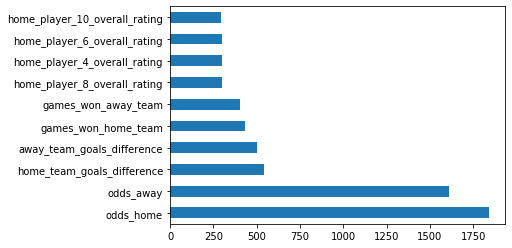

In [13]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=25)
fit = bestfeatures.fit(features, labels)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(features.columns)
#concat two dataframes for better visualization 
feat_importances = pd.Series(fit.scores_, index=features.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

C:\Users\35192\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


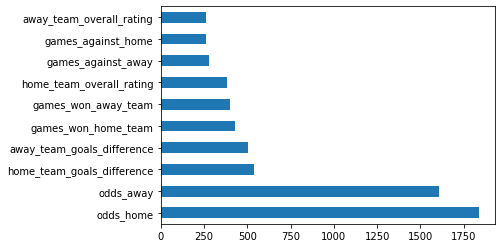

In [21]:
# Features Minified
bestfeatures = SelectKBest(score_func=f_classif, k='all')
fit = bestfeatures.fit(features_min, labels)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(features_min.columns)
#concat two dataframes for better visualization 
feat_importances = pd.Series(fit.scores_, index=features_min.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

### Feature Weighting

Uses statistical tests that can be used to select those features that have the strongest relationship with the output variable.

C:\Users\35192\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\35192\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


[0.03290375 0.03217989 0.0313864  0.03236006 0.0234421  0.02525418
 0.03114622 0.02987529 0.03065619 0.03134101 0.03165008 0.03185248
 0.03354938 0.03231523 0.03097952 0.03299548 0.03427873 0.03121076
 0.03134863 0.0324484  0.03010711 0.03176864 0.03035072 0.03147994
 0.03163425 0.03104888 0.03147308 0.03036379 0.04624485 0.03190419
 0.05045076]


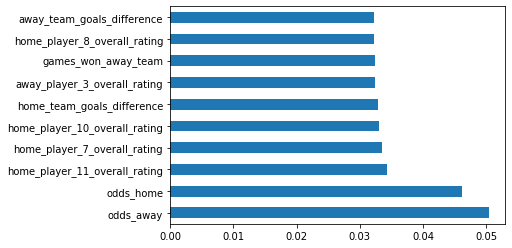

In [14]:
model = ExtraTreesClassifier()
model.fit(features, labels)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=features.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

C:\Users\35192\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\35192\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


[0.10356262 0.10025433 0.07623539 0.08181143 0.03692849 0.04083243
 0.10983202 0.11437724 0.11975733 0.09741745 0.11899126]


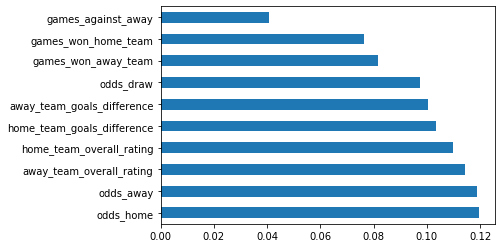

In [22]:
# Minified
model = ExtraTreesClassifier()
model.fit(features_min, labels)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=features_min.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

### Principal Component Analysis (PCA)

Using the data covariance and it's eigenvalue decomposition, calculates the most relevant features on the dataset.

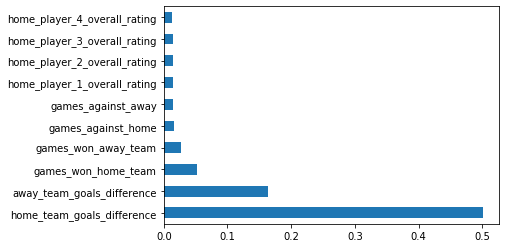

In [16]:
pca = PCA(n_components=31)
pca.fit(features)
variances = pd.DataFrame()
variances.loc[:,'features'] = features.columns
variances.loc[:,'variances'] = pca.explained_variance_ratio_ 
feat_importances = pd.Series(pca.explained_variance_ratio_, index=features.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

#### Feature Selection Results 

By analyzing the results of the 3 techniques applied (Univariate Selection, Feature Importance and PCA) we can conclude that there isn't any feature that has a special relevance on the output (beside the ODDS). Meaning that the output depends not of a specific feature, but of the features as a group.

# Normalizing Data

In [28]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

features = normalize(features)
features_min = normalize(features_min)
features.head(5)

,home_team_goals_difference,away_team_goals_difference,games_won_home_team,games_won_away_team,games_against_home,games_against_away,home_player_1_overall_rating,home_player_2_overall_rating,home_player_3_overall_rating,home_player_4_overall_rating,home_player_5_overall_rating,home_player_6_overall_rating,home_player_7_overall_rating,home_player_8_overall_rating,home_player_9_overall_rating,home_player_10_overall_rating,home_player_11_overall_rating,away_player_1_overall_rating,away_player_2_overall_rating,away_player_3_overall_rating,away_player_4_overall_rating,away_player_5_overall_rating,away_player_6_overall_rating,away_player_7_overall_rating,away_player_8_overall_rating,away_player_9_overall_rating,away_player_10_overall_rating,away_player_11_overall_rating,odds_home,odds_draw,odds_away
0,0.378788,0.384615,0.0,0.0,0.0,0.0,0.3125,0.319149,0.500000,0.229167,0.438596,0.382979,0.333333,0.50,0.185185,0.395833,0.339623,0.309524,0.595745,0.361702,0.270833,0.358491,0.615385,0.469388,0.46,0.538462,0.518519,0.40,0.335762,0.451373,0.486014
1,0.378788,0.384615,0.0,0.0,0.0,0.0,0.4375,0.468085,0.409091,0.416667,0.473684,0.574468,0.500000,0.52,0.537037,0.458333,0.471698,0.571429,0.531915,0.510638,0.520833,0.584906,0.576923,0.510204,0.52,0.480769,0.611111,0.50,0.333007,0.465906,0.479892
2,0.378788,0.384615,0.0,0.0,0.0,0.0,0.5000,0.638298,0.545455,0.562500,0.649123,0.638298,0.625000,0.58,0.629630,0.375000,0.547170,0.285714,0.510638,0.404255,0.375000,0.264151,0.461538,0.469388,0.48,0.250000,0.333333,0.42,0.710395,0.330977,0.156124
3,0.393939,0.415385,0.1,0.1,0.0,0.0,0.3125,0.319149,0.500000,0.479167,0.543860,0.319149,0.187500,0.38,0.185185,0.375000,0.339623,0.428571,0.638298,0.638298,0.500000,0.603774,0.673077,0.530612,0.64,0.615385,0.555556,0.52,0.218070,0.434312,0.624030
4,0.348485,0.384615,0.0,0.0,0.0,0.0,0.3750,0.510638,0.363636,0.395833,0.438596,0.404255,0.479167,0.50,0.444444,0.250000,0.283019,0.357143,0.425532,0.319149,0.312500,0.301887,0.346154,0.448980,0.30,0.346154,0.425926,0.44,0.580025,0.418060,0.242619


# Dataset Division

### K cross fold validation

To test how well our model is able to get trained by some data and then predict data it hasn't seen.

In [16]:
# Categorical Data to Numeric
labels.label, mapping_index = pd.Series(labels.label).factorize()

In [25]:
mapping_index

Index(['Win', 'Defeat', 'Draw'], dtype='object')

In [30]:
#Splitting the data into Train, Validation

X = np.array(features)
y = np.array(labels['label'])
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)
counter = 1


for train_index, test_index in skf.split(X, y):
    # print("TRAIN:", train_index, "TEST:", test_index)
    val = features.iloc[test_index, :]

    train = features.iloc[train_index, :]
    
    val.to_csv(os.path.join('folds' + os.sep + 'validate', str(counter) + '.csv'))
    train.to_csv(os.path.join('folds' + os.sep + 'train', str(counter) + '.csv'))
    
    val_target = labels.iloc[test_index, :]
    train_target = labels.iloc[train_index, :]
    val_target.to_csv(os.path.join('targets' + os.sep + 'validate', str(counter) + '.csv'))
    train_target.to_csv(os.path.join('targets' + os.sep + 'train', str(counter) + '.csv'))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    counter += 1


In [31]:
X = np.array(features_min)
y = np.array(labels['label'])
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)
counter = 1


for train_index, test_index in skf.split(X, y):
    # print("TRAIN:", train_index, "TEST:", test_index)
    val = features_min.iloc[test_index, :]

    train = features_min.iloc[train_index, :]
    
    val.to_csv(os.path.join('folds_min' + os.sep + 'validate', str(counter) + '.csv'))
    train.to_csv(os.path.join('folds_min' + os.sep + 'train', str(counter) + '.csv'))
    
    val_target = labels.iloc[test_index, :]
    train_target = labels.iloc[train_index, :]
    val_target.to_csv(os.path.join('targets_min' + os.sep + 'validate', str(counter) + '.csv'))
    train_target.to_csv(os.path.join('targets_min' + os.sep + 'train', str(counter) + '.csv'))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    counter += 1